In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm

## Load data into a Pandas dataframe

In [2]:
files = (
    ("laptop_cdklm_profiling.npz", "Laptop"),
    ("desktop_cdklm_profiling.npz", "Desktop"),
    ("supercomputer_fermi_cdklm_profiling.npz", "Met"),
    ("supercomputer_fermi_cdklm_profiling.npz", "Fermi")
)

#Create column names
columns = ["labels"]
for _, label in files:
    columns = columns + ["megacells " + label]
    
#Create index names:
with np.load(files[0][0]) as data:
    index = data['versions']
    labels = data['labels']

df = pd.DataFrame(columns=columns, index=index)
df['labels'] = labels

for filename, label in files:
    with np.load(filename) as data:
        versions = data['versions']
        assert np.all(versions == df.index)
        df["megacells " + label] = data['megacells']
        
print(df)

                                                                            labels  \
a126bab97e690b7c642814e3c8b96f9879adf487  original (per arch optimized block size)   
5d817bb7cd2b369039117d19aae7d669a9a2e53a            Optimized shared memory use Hm   
2e5da01457874ad5087398da77b9102ee991fb94       Optimized shared memory use RHx/RHy   
fcd145c8c29f3d38a024685fdd0fc3cf9580366c             Optimized shared memory use Q   
74e957bb41e391a5c5fbb19c3cac393079272dd3             Optimized shared memory use F   
5aba525d1d64937c03e8d2b33bb7f6d80b97a81a             Optimized shared memory use G   
addb061fe1cfccebb6fab70f9826be3752162b0b            Optimized shared memory use Qy   
aab115045fd6d313940fa37be3149155ba4ead70                      Made variables const   
f6a911368b429df608eb5e1218c28bc14d6ffbe2         Updated blocksize experiment code   
339eb0c9a3bf04875507fab24d8924e24718a2eb                Changed default block size   
1319edf92c20b8d5fd9fc8c0e0ed58176f9cc2ba              

## Plot results

<Figure size 432x288 with 0 Axes>

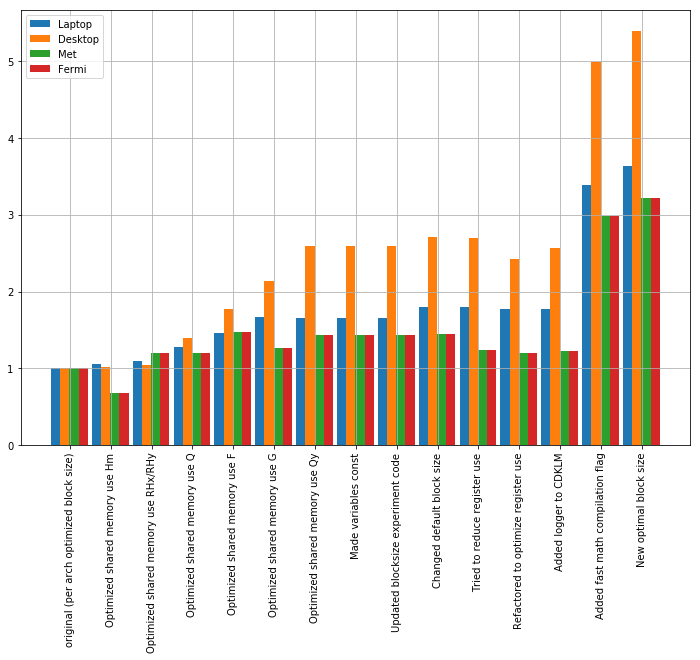

In [3]:
fig = plt.figure()

fig, ax = plt.subplots(figsize=(12,8))

num_bars = len(files)
bar_width = 0.9 / num_bars
bar_offset = 0.05

x = np.arange(len(versions))
architectures = list(zip(*files))[1]
num_architectures = len(architectures)

for i, label in enumerate(architectures):
    values = df['megacells ' + label]
    values = values / values[0] #Normalize
    ax.bar(x+2*bar_offset + (i - num_architectures/2)*bar_width, values, bar_width, label=label)

plt.xticks(x, df['labels'], rotation='vertical')
plt.grid()

plt.legend()

In [4]:
with np.load(outfile_desktop) as data:
    for i in data:
        print (i)
    print (data['versions'])
    print (versions)

NameError: name 'outfile_desktop' is not defined